# End-to-end MNIST project
This notebook is divided into four parts: <br>
1. Preprocessing
2. Selection of classifiers
3. Evaluation
4. Selection of final model

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import sys
import os.path

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [5]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten #dense == fully connected layer 
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils 

/home/sathiesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Preprocessing 

In [7]:
NB_DIR = %pwd

In [8]:
PATH = (f'{NB_DIR}/').replace('nbs/','')+'csv/'
LABELS = 'handwritten_digits_labels.csv'
IMAGES = 'handwritten_digits_images.csv'

In [9]:
df_X,df_y  = pd.read_csv(PATH+IMAGES),pd.read_csv(PATH+LABELS)

In [10]:
df_X.shape, df_y.shape

((69999, 784), (69999, 1))

In [11]:
#count number of unique values in the dataset
unique_values = df_y['0'].unique()

In [12]:
img_index = []
for i in unique_values: 
    img_index.append(df_y.loc[df_y['0'] == i].index[0])

/home/sathiesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


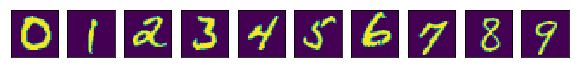

In [13]:
#https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645 

fig=plt.figure(figsize=(10,10))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    img = df_X.iloc[img_index[i-1]].as_matrix()
    img = img.reshape((28, 28))
    fig.add_subplot(rows, columns, i)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(img)
plt.show()

In [14]:
df_y['index'] = df_y.index

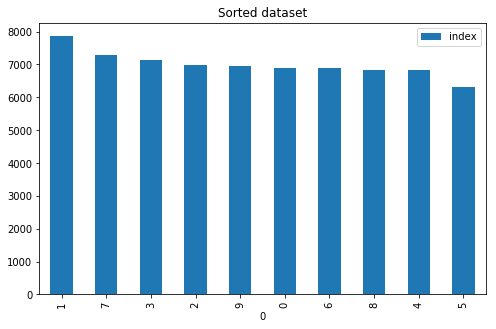

In [15]:
df_sorted = df_y.pivot_table(index='0', aggfunc=len).sort_values('index', ascending=False) 
df_sorted.plot(kind='bar',figsize=(8,5), title='Sorted dataset')

In [16]:
df_y = df_y.drop(['index'], axis=1)

In [17]:
X, y= np.array(df_X), np.array(df_y)

### Create train and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train_nn, y_train_nn =X_train[:], y_train[:]

### Normalization 
Scale the features between 0.0 and 1.0

In [20]:
X_train_nn = X_train_nn.astype('float32')
X_train_nn/=255

### One-hot encoding 
We saw in the last exercise that one hot encoding gives better results in neural networks. In a random forrest it might be better to use the labels as they are. 

In [21]:
y_train_nn = np_utils.to_categorical(y_train_nn,10)

# 2. Selection of classifiers 

In [22]:
clf_val_acc = {}

### Neural network

In [23]:
def create_nn(): 
    nn_model = Sequential()
    nn_model.add(Dense(350, input_dim=784, activation='tanh')) 
    nn_model.add(Dense(10, activation='softmax')) # input 1, activation sigmoid
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [24]:
nn_model = create_nn()
%time nn_model.fit(X_train_nn, y_train_nn,validation_split=0.2, epochs=3, batch_size=16)

Train on 44799 samples, validate on 11200 samples
Epoch 1/3
44799/44799 [==============================] - 6s 140us/step - loss: 0.0465 - acc: 0.9844 - val_loss: 0.0307 - val_acc: 0.9899
Epoch 2/3
44799/44799 [==============================] - 6s 131us/step - loss: 0.0222 - acc: 0.9926 - val_loss: 0.0236 - val_acc: 0.9919
Epoch 3/3
44799/44799 [==============================] - 6s 131us/step - loss: 0.0141 - acc: 0.9953 - val_loss: 0.0182 - val_acc: 0.9943
CPU times: user 56.7 s, sys: 28 s, total: 1min 24s
Wall time: 18.2 s


In [25]:
nn_history = nn_model.history.history
clf_val_acc['NN'] = nn_history['val_acc'][-1]

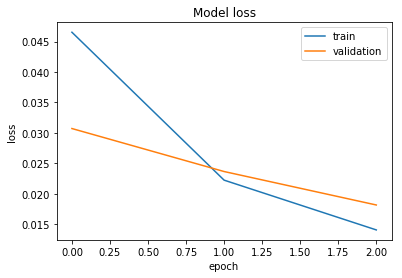

In [26]:
plt.plot(nn_history['loss'])
plt.plot(nn_history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

As long as the training and validation loss are in the same range we don’t overfit or underfit. <br>
Overfitting happens when the training loss is much lower than the validation loss and underfitting is in the opposite case. 


### CNN 

In [27]:
X_train_nn = X_train_nn.reshape([-1,1, 28, 28]) #reshape dimension to 1x28x28
X_train_nn.shape

(55999, 1, 28, 28)

In [28]:
#Dropout is used to reduce overfitting. 
#The activation function relu: max(0,value)
def create_cnn():
    cnn_model = Sequential()
    cnn_model.add(Convolution2D(32,(3,3), activation='relu', input_shape= (1,28,28), data_format='channels_first')) #32 filters with 3x3 filter
    cnn_model.add(Convolution2D(64,(3,3), activation='relu', data_format='channels_first')) #64 filters with 3x3 filter
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Flatten()) #flatten to a vector
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(10, activation='softmax'))
    cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # binary_crossentropy
    return cnn_model

In [29]:
cnn_model = create_cnn()

In [30]:
#verbose=1 will show you an animated progress bar like this: #######
%time cnn_model.fit(X_train_nn, y_train_nn, validation_split=0.2,batch_size=16, epochs=3, verbose=1)

Train on 44799 samples, validate on 11200 samples
Epoch 1/3
44799/44799 [==============================] - 91s 2ms/step - loss: 0.0414 - acc: 0.9861 - val_loss: 0.0114 - val_acc: 0.9962
Epoch 2/3
44799/44799 [==============================] - 87s 2ms/step - loss: 0.0202 - acc: 0.9934 - val_loss: 0.0099 - val_acc: 0.9967
Epoch 3/3
44799/44799 [==============================] - 88s 2ms/step - loss: 0.0158 - acc: 0.9948 - val_loss: 0.0095 - val_acc: 0.9969
CPU times: user 40min 47s, sys: 5min 7s, total: 45min 55s
Wall time: 4min 25s


In [31]:
cnn_history = cnn_model.history.history
clf_val_acc['CNN'] = cnn_history['val_acc'][-1]

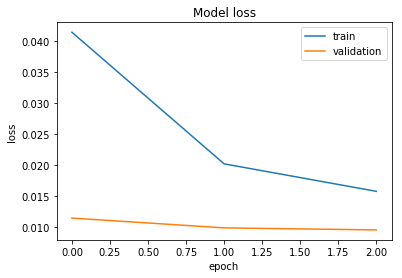

In [32]:
plt.plot(cnn_history['loss'])
plt.plot(cnn_history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#### Preprocessing for other models

In [33]:
X_train = X_train.astype('float32')
X_train/=255

#### Label encoding

In [34]:
y_train = y_train.ravel()

### XGBoost

In [35]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.0, 1.0, 1.5],
        'max_depth': [5, 6, 7, 8]
        }

In [36]:
xgb_clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')

In [37]:
n_iter =  20 #Change this value for more/less combinations
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_iter=n_iter, scoring='accuracy', cv=5)

In [38]:
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sathiesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')


In [39]:
clf_val_acc['XGB'] = random_search.best_score_

In [40]:
xgb_clf = random_search.best_estimator_
%time xgb_clf.fit(X_train, y_train) 

CPU times: user 12.4 s, sys: 9.37 s, total: 21.7 s
Wall time: 21.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')

### KNN

In [41]:
#Takes time
'''
param_grid = {
        'n_neighbors': [5, 10]
        }
#grid =  GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
#grid.fit(X_train,y_train)
#grid.best_params_
'''

"\nparam_grid = {\n        'n_neighbors': [5, 10]\n        }\n#grid =  GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')\n#grid.fit(X_train,y_train)\n#grid.best_params_\n"

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [43]:
knn_clf = KNeighborsClassifier()#grid.best_estimator_
%time knn_clf.fit(X_train, y_train) 

CPU times: user 8.6 s, sys: 20 ms, total: 8.62 s
Wall time: 8.59 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [44]:
knn_pred = knn_clf.predict(X_val)
clf_val_acc['KNN'] = accuracy_score(y_val, knn_pred)*100

# 3. Evaluation

### Accuracy on validation set

In [45]:
for key, value in clf_val_acc.items():
    print(key+': '+str(value) + '%')

NN: 0.994258931194033%
CNN: 0.9969375019414084%
XGB: 0.9697673172735227%
KNN: 96.77678571428572%


### Compare NN vs CNN

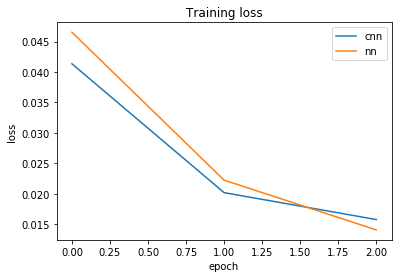

In [46]:
plt.plot(cnn_history['loss'])
plt.plot(nn_history['loss'])
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['cnn', 'nn'])
plt.show()

# 4. Selection of final model 
Our final model is a convolutional neural network.

In [47]:
#Train on the entire training data
cnn_model = create_cnn()
%time cnn_model.fit(X_train_nn, y_train_nn, batch_size=16, epochs=3, verbose=1)

Epoch 1/3
55999/55999 [==============================] - 108s 2ms/step - loss: 0.0363 - acc: 0.9879
Epoch 2/3
55999/55999 [==============================] - 105s 2ms/step - loss: 0.0173 - acc: 0.9943
Epoch 3/3
55999/55999 [==============================] - 107s 2ms/step - loss: 0.0129 - acc: 0.9957
CPU times: user 45min 22s, sys: 6min 30s, total: 51min 53s
Wall time: 5min 20s


### Preprocessing the test data

In [48]:
X_test = X_test.astype('float32')
X_test/=255
X_test = X_test.reshape([-1,1, 28, 28])

In [49]:
y_test_nn = np_utils.to_categorical(y_test,10)
y_test = y_test.ravel()

### Accuracy on test data

In [50]:
scores = cnn_model.evaluate(X_test, y_test_nn)
print(scores[1]*100)

14000/14000 [==============================] - 12s 873us/step
99.7957137448447


### Confusion matrix: precision/recall


In [51]:
y_pred = cnn_model.predict_classes(X_test)

In [52]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1365
          1       0.99      1.00      1.00      1592
          2       0.99      0.99      0.99      1388
          3       0.99      0.99      0.99      1394
          4       0.99      0.99      0.99      1373
          5       0.99      0.99      0.99      1243
          6       0.99      0.99      0.99      1397
          7       0.99      0.99      0.99      1453
          8       0.99      0.99      0.99      1358
          9       0.99      0.98      0.98      1437

avg / total       0.99      0.99      0.99     14000



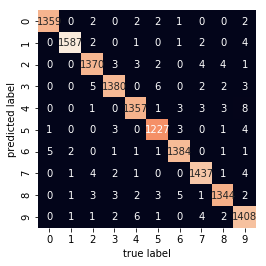

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.figsize=(25,25),

In [54]:
# Eksample of a wrong predicted image 
def wrong_predicted_class(y_label, y_pred): 
    wrong_index = []
    for idx, y in enumerate(y_label):
        if y != y_pred[idx]: wrong_index.append(idx)
        if len(wrong_index) == 6: return wrong_index

In [55]:
wrong_index = wrong_predicted_class(y_test, y_pred)

### Example of missclassified class

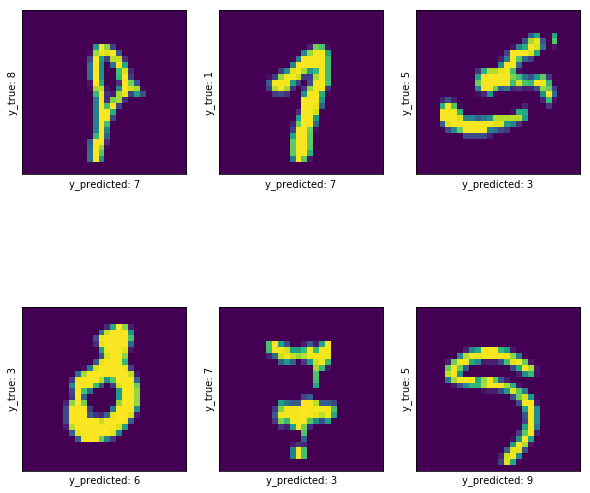

In [56]:
fig=plt.figure(figsize=(10,10))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    plottable_image = np.reshape(X_test[wrong_index[i-1]], (28, 28))
    fig.add_subplot(rows, columns, i)
    plt.yticks([])
    plt.xticks([])
    plt.ylabel('y_true: ' + str(y_test[wrong_index[i-1]]))
    plt.xlabel('y_predicted: ' + str(y_pred[wrong_index[i-1]]))

    plt.imshow(plottable_image)
plt.show()